In [32]:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpol
from pyccl._core import UnlockInstance
from scipy import signal

In [34]:
#import BCMprofiles_functional as BCMprofiles
import BCMprofiles_hopefulFinal as BCMprofiles
BCMprofiles.__all__

/Users/lambe/Documents/GitHub/Oxford-Intern-2024/Oxford-Internship-Practices/BCM/BCMprofiles_hopefulFinal.py:156: SyntaxWarning: invalid escape sequence '\ '
  """Creating a class for the stellar density profile
/Users/lambe/Documents/GitHub/Oxford-Intern-2024/Oxford-Internship-Practices/BCM/BCMprofiles_hopefulFinal.py:261: SyntaxWarning: invalid escape sequence '\ '
  """Creating a class for the bound gas density profile where:


('Initialiser',
 'StellarProfile',
 'EjectedGasProfile',
 'BoundGasProfile',
 'CDMProfile',
 'BCMProfile')

In [36]:
help(ccl.halos.profiles.profile_base.HaloProfile.__init__)

Help on function __init__ in module pyccl.halos.profiles.profile_base:

__init__(self, *, mass_def, concentration=None, is_number_counts=False)
    Initialize self.  See help(type(self)) for accurate signature.



# Setting up pars & profiles

In [55]:
hmd_200c = ccl.halos.MassDef200c # use a mass definition with Delta = 200
cM = ccl.halos.ConcentrationDuffy08(mass_def=hmd_200c)
cosmo = ccl.Cosmology(Omega_c = 0.25, Omega_b=0.05, h=0.7, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

trial_r = np.geomspace(1E-2,1E8,100000) # geomspace is like linspace, but evenly spaces on a logscale
trial_k = np.geomspace(5E-3, 5E1, 100_000) # np.geomspace(1E-3,9E1,100000) # np.geomspace(1E-3,1E2,100000)
trial_M = np.array([3E12,6E13, 1E14])
trial_gamma = 1.1  # working with z = 0 (today) ; therefore a = 1 [default]
trial_f_bd = 0.6

## Loading profiles, with fourier_analytic = True

In [58]:
cdm_profile = BCMprofiles.CDMProfile(cosmo, hmd_200c, cM, trial_gamma)
stel_profile = BCMprofiles.StellarProfile(cosmo, hmd_200c, cM, trial_gamma)
ej_profile = BCMprofiles.EjectedGasProfile(cosmo, hmd_200c, cM, trial_gamma)
bd_profile = BCMprofiles.BoundGasProfile(cosmo, hmd_200c, cM, trial_gamma)
bcm_profile = BCMprofiles.BCMProfile(cosmo, hmd_200c, cM, trial_gamma)

In [60]:
#cdm_profile.update_parameters(A_star=2)
stel_profile.A_star # see that update_parameters (inherited) works

0.03

In [62]:
cdm_real = cdm_profile._real(cosmo, trial_r, trial_M)
stel_real = stel_profile._real(cosmo, trial_r, trial_M)
ej_real = ej_profile._real(cosmo, trial_r, trial_M)
bd_real = bd_profile._real(cosmo, trial_r, trial_M)
bcm_real = bcm_profile._real(cosmo, trial_r, trial_M)#, no_fraction=True, 
                            # choose_fracs={'ejected': 0.1, 'bound': 0.4, 'stellar': 0.3, 'cdm': 0.2})

The chosen components with their respective mass fractions are:  {'ejected': 0.1, 'bound': 0.4, 'stellar': 0.3, 'cdm': 0.2}


In [79]:
cdm_fourier = cdm_profile._fourier(trial_k, trial_M)
stel_fourier = stel_profile._fourier(trial_k, trial_M)
ej_fourier = ej_profile._fourier(trial_k, trial_M)
bd_fourier = bd_profile._fourier(trial_k, trial_M)
bcm_fourier = bcm_profile._fourier(trial_k, trial_M)#, no_fraction=True, 
                                  # choose_fracs={'ejected': 0.6, 'bound': 0.4})#, 'stellar': 1.3, 'cdm': 3.2})

In [66]:
prof_dict = {'e': ej_fourier, 'b': bd_fourier[0], 's': stel_fourier, 'c': cdm_fourier}
choose_fracs={'e': 1, 'b': 1, 's': 1, 'c': 1}

In [68]:
bd_profile.update_parameters(Gamma=1.2)

In [70]:
np.sum(np.array([cdm_fourier, stel_fourier, ej_fourier, bd_fourier[0]]), axis=0)

array([[2.99999717e+12, 2.99999717e+12, 2.99999717e+12, ...,
        3.48147161e+11, 3.48119751e+11, 3.48092334e+11],
       [5.99997469e+13, 5.99997468e+13, 5.99997468e+13, ...,
        1.76440201e+12, 1.76431091e+12, 1.76421955e+12],
       [9.99994811e+13, 9.99994810e+13, 9.99994809e+13, ...,
        2.21013769e+12, 2.20990496e+12, 2.20967187e+12]])

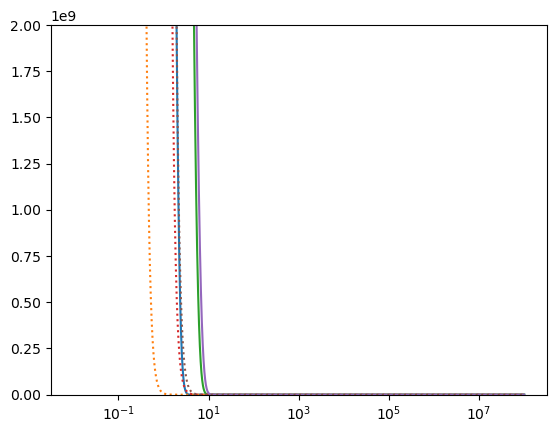

In [72]:
four_plot, four_plot2, four_plot3, four_plot4 = ej_real, bd_real, stel_real, cdm_real
for prof, prof2, mass in zip(four_plot, four_plot2, trial_M):
    plt.plot(trial_r, prof)
    plt.plot(trial_r, prof2, ':')
   # plt.axhline(mass, linestyle='--', zorder=1)
#plt.yscale('log')
plt.ylim(0,0.2E10)
plt.xscale('log');

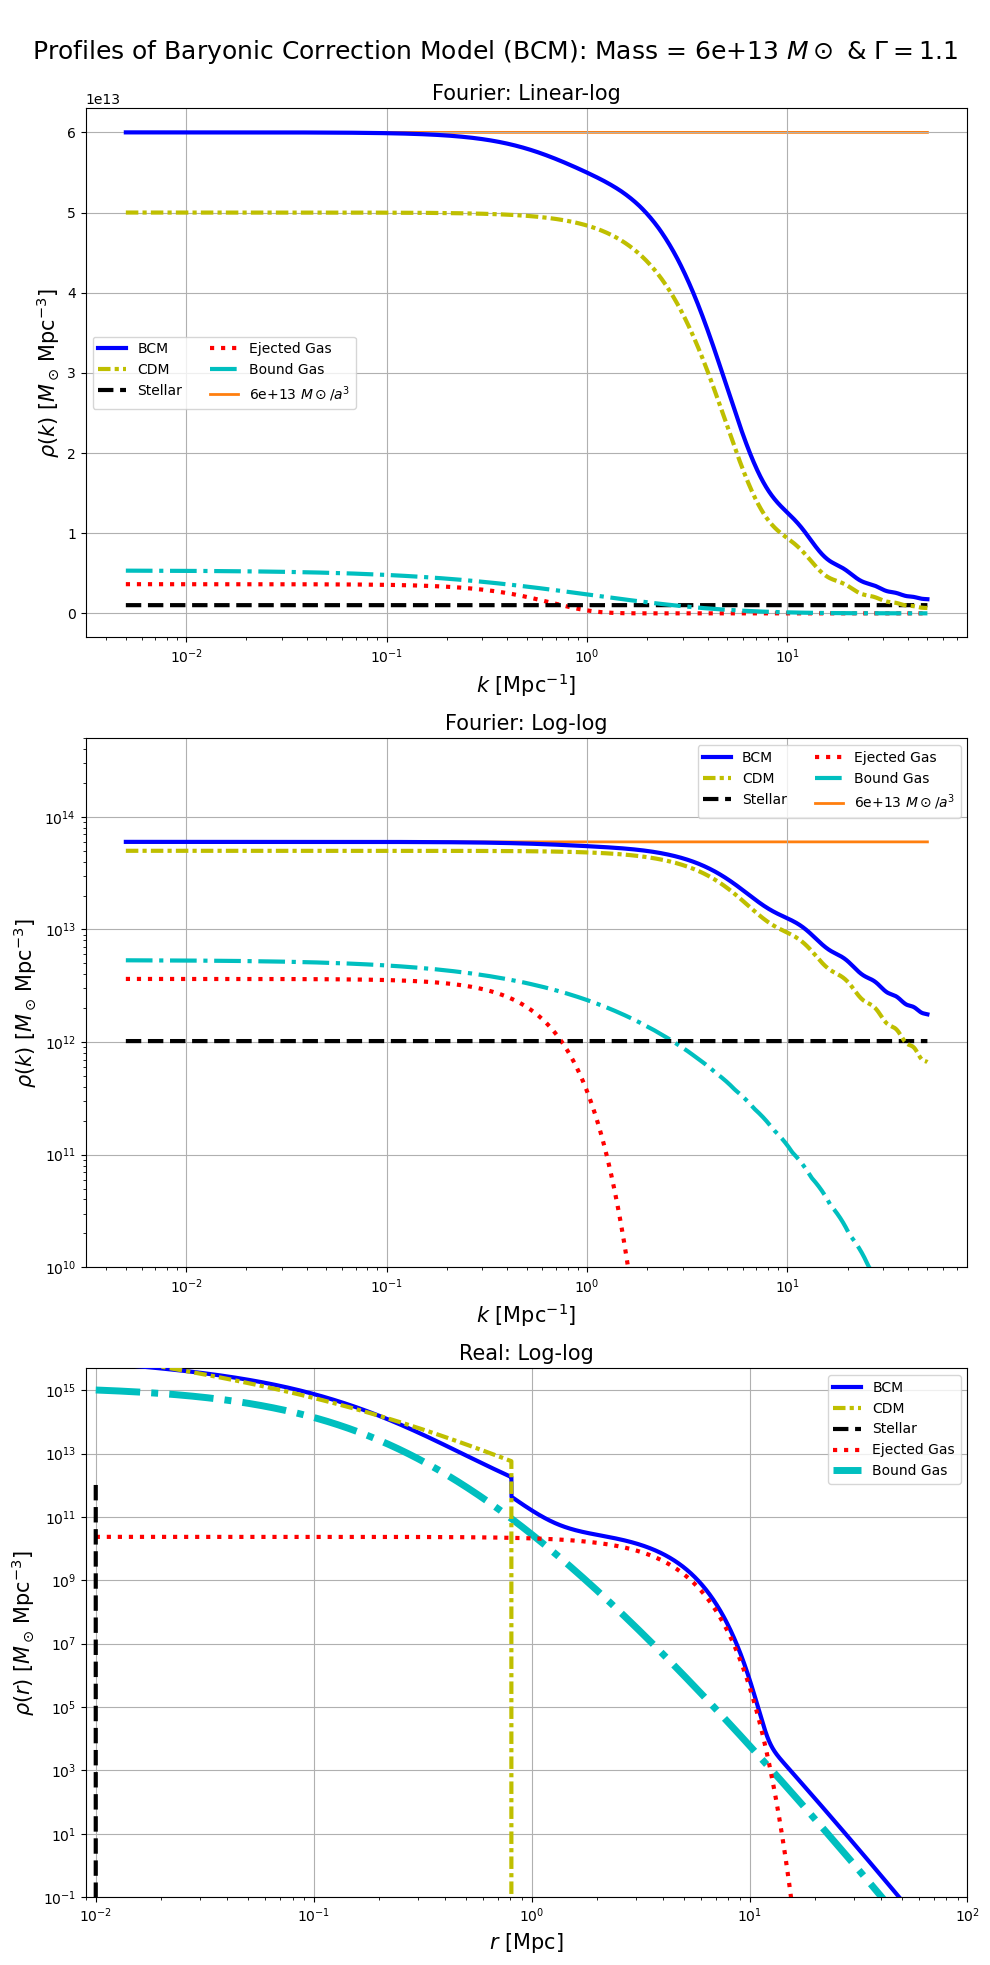

In [81]:
i = 1
title_combined = f'\nProfiles of Baryonic Correction Model (BCM): Mass = {trial_M[i]:.1g} $M \\odot$ & $\\Gamma = ${trial_gamma}\n' 
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,20))
fig.suptitle(title_combined, fontsize=18)

ax1.plot(trial_k, bcm_fourier[i], 'b-', 
         lw=3, zorder = 5, label='BCM')
ax1.plot(trial_k, cdm_fourier[i], linestyle=(0, (3,1,1,1)), color='y', lw=3, 
         zorder=6, label='CDM')
ax1.plot(trial_k, stel_fourier[i], 'k--', lw=3, zorder = 3, label='Stellar')
ax1.plot(trial_k, ej_fourier[i], 'r:', 
         lw=3, zorder = 2, label='Ejected Gas')
ax1.plot(trial_k, bd_fourier[0,i], 'c-.', 
         lw=3, zorder = 4, label='Bound Gas')
ax1.plot(trial_k, 1*trial_k + trial_M[i], 'tab:orange', zorder=1, lw=2, label=f'{trial_M[i]:.1g} $M \\odot /a^3$')
    
ax1.set_ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
ax1.set_xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
ax1.set_title('Fourier: Linear-log', fontsize=15)
ax1.grid(True)
ax1.legend(loc='best', ncol=2)
ax1.set_xscale('log'); 
##########################
ax2.plot(trial_k, bcm_fourier[i], 'b-', lw=3, zorder = 5, label='BCM')
ax2.plot(trial_k, cdm_fourier[i], linestyle=(0, (3,1,1,1)), color='y', lw=3, 
         zorder=6, label='CDM')
ax2.plot(trial_k, stel_fourier[i], 'k--', lw=3, zorder = 5, label='Stellar')
ax2.plot(trial_k, ej_fourier[i], 'r:', lw=3, zorder = 4, label='Ejected Gas')
ax2.plot(trial_k, bd_fourier[0,i], 'c-.', lw=3, zorder = 3, label='Bound Gas')
ax2.plot(trial_k, 1*trial_k + trial_M[i], 'tab:orange', zorder=1, lw=2, label=f'{trial_M[i]:.1g} $M \\odot /a^3$')
    
ax2.set_ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
ax2.set_xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
ax2.set_title('Fourier: Log-log', fontsize=15)
ax2.grid(True)
ax2.legend(loc='best', ncol=2)
ax2.set_xscale('log'); 
ax2.set_ylim(1E10, 5E14)
#ax2.set_ylim(5E10)
ax2.set_yscale('log');
#########################
ax3.plot(trial_r, bcm_real[i], 'b-', lw=3, zorder = 3, label='BCM')
ax3.plot(trial_r, cdm_real[i], linestyle=(0, (3,1,1,1)), color='y', lw=3, 
         zorder=7, label='CDM')
ax3.plot(trial_r, stel_real[i], 'k--', lw=3, zorder = 5, label='Stellar')
ax3.plot(trial_r, ej_real[i], 'r:', lw=3, zorder = 4, label='Ejected Gas')
ax3.plot(trial_r, bd_real[i], 'c-.', lw=5, zorder = 3, label='Bound Gas')
    
ax3.set_ylabel(r'$\rho(r)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
ax3.set_xlabel(r'$r\, \,[{\rm Mpc}]$', fontsize=15);
ax3.set_title('Real: Log-log', fontsize=15)
ax3.grid(True)
ax3.legend(loc='best')
ax3.set_xscale('log'); 
ax3.set_ylim(1E-1, 5E15)
ax3.set_xlim(9E-3, 1E2)
ax3.set_yscale('log');

fig.tight_layout();
#fig.savefig('./BCM_real&Fourier_plot_0108.pdf', dpi=500);

In [77]:
help(stel_profile)

Help on StellarProfile in module BCMprofiles_hopefulFinal object:

class StellarProfile(BCM_Initialiser)
 |  StellarProfile(self, cosmo, mass_def, concentration, Gamma, fourier_analytic=True, delta=200, eta_b=0.5, gammaRange=(3, 20), ngamma=64, qrange=(0.0001, 100.0), nq=64, limInt=(0.001, 5000.0), beta=0.6, M_c=31622776601683.793, M_star=3162277660168.3794, A_star=0.03, sigma_star=1.2, projected_analytic=False, cumul2d_analytic=False, truncated=True)
 |
 |  Creating a class for the stellar density profile
 |  where:
 |  .. math::
 |
 |      \rho_*(r)\ = Ma ^{-3} g_*(r)\  & g_*(r)\ \equiv \delta^D(\mathbf{x}) (\text{a Dirac delta function centred at }r=0).
 |  The normalised Fourier profile is then given by:
 |  .. math::
 |      \tilde{g}_*(k)\ = 1.
 |
 |  Inherits __init__ , update_parameters, & _f_stell methods from Initialiser parent class.
 |
 |  To do later: Change real profile of stellar from delta function to (...)
 |
 |  Method resolution order:
 |      StellarProfile
 |      